### Imports

In [18]:
import pandas as pd
import numpy as np
from pathlib import Path
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

### Constants

In [19]:
base_path = Path("/Users/tusharsingh/Work/Project/tcga-mldl/results/data/data_splits")
plotdir = Path("/Users/tusharsingh/Work/Project/tcga-mldl/results/plots")

split_sets = {
    "5pct_80": base_path / "5pct_80",
    "15pct_80": base_path / "15pct_80",
    "25pct_80": base_path / "25pct_80"
}


### Load Data

In [20]:
def load_split_data(split_path):
    split_path = Path(split_path)
    X_train = pd.read_csv(split_path / "X_train.csv", index_col=0)
    X_test = pd.read_csv(split_path / "X_test.csv", index_col=0)
    y_train = pd.read_csv(split_path / "y_train.csv", index_col=0).squeeze()
    y_test = pd.read_csv(split_path / "y_test.csv", index_col=0).squeeze()
    return X_train, X_test, y_train, y_test


### GridsearchCV Wrapper

In [21]:
def run_rf_gridsearch(X_train, y_train, X_test, y_test, cv_folds=5):
    rf = RandomForestClassifier(random_state=42)

    param_grid = {
        'n_estimators': [100,200,250],
        'max_depth': [None,5,12,15],
        'min_samples_split': [2,3]
    }

    grid = GridSearchCV(
        rf, param_grid, cv=StratifiedKFold(n_splits=cv_folds, shuffle=True, random_state=42),
        scoring='accuracy', n_jobs=-1, verbose=0
    )

    grid.fit(X_train, y_train)
    best_model = grid.best_estimator_
    y_pred = best_model.predict(X_test)

    return {
        "best_params": grid.best_params_,
        "cv_best_score": grid.best_score_,
       # "test_acc": accuracy_score(y_test, y_pred),
        "report": classification_report(y_test, y_pred, output_dict=True),
        "conf_matrix": confusion_matrix(y_test, y_pred)
    }


In [22]:
results_rf_5fold = []

for name, path in split_sets.items():
    X_train, X_test, y_train, y_test = load_split_data(path)
    out = run_rf_gridsearch(X_train, y_train, X_test, y_test, cv_folds=5)

    results_rf_5fold.append({
        "Split": name,
        "Samples": X_train.shape[0],
        "Features": X_train.shape[1],
        "CV (5-fold) Accuracy": round(out["cv_best_score"], 4),
        #"Test Accuracy": round(out["test_acc"], 4),
        "Best Params": out["best_params"]
    })

results_rf_5fold = pd.DataFrame(results_rf_5fold).sort_values("CV (5-fold) Accuracy", ascending=False)
results_rf_5fold


,Split,Samples,Features,CV (5-fold) Accuracy,Best Params
1,15pct_80,408,5870,0.6472,"{'max_depth': 15, 'min_samples_split': 2, 'n_e..."
0,5pct_80,408,1956,0.6447,"{'max_depth': 12, 'min_samples_split': 3, 'n_e..."
2,25pct_80,408,9784,0.6300,"{'max_depth': 15, 'min_samples_split': 2, 'n_e..."


In [23]:
results_rf_10fold = []

for name, path in split_sets.items():
    X_train, X_test, y_train, y_test = load_split_data(path)
    out = run_rf_gridsearch(X_train, y_train, X_test, y_test, cv_folds=10)

    results_rf_10fold.append({
        "Split": name,
        "Samples": X_train.shape[0],
        "Features": X_train.shape[1],
        "CV (10-fold) Accuracy": round(out["cv_best_score"], 4),
        #"Test Accuracy": round(out["test_acc"], 4),
        "Best Params": out["best_params"]
    })

results_rf_10fold = pd.DataFrame(results_rf_10fold).sort_values("CV (10-fold) Accuracy", ascending=False)
results_rf_10fold


,Split,Samples,Features,CV (10-fold) Accuracy,Best Params
1,15pct_80,408,5870,0.6620,"{'max_depth': 15, 'min_samples_split': 2, 'n_e..."
0,5pct_80,408,1956,0.6595,"{'max_depth': 5, 'min_samples_split': 2, 'n_es..."
2,25pct_80,408,9784,0.6376,"{'max_depth': None, 'min_samples_split': 2, 'n..."


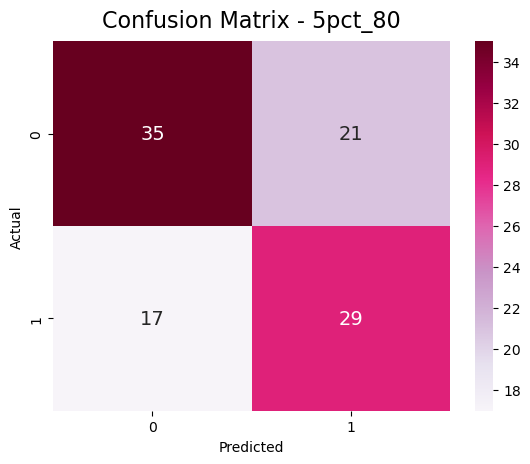

In [24]:
# For any split, e.g., "25pct_80"
X_train, X_test, y_train, y_test = load_split_data(split_sets["5pct_80"])
out = run_rf_gridsearch(X_train, y_train, X_test, y_test, cv_folds=5)

# Plot confusion matrix
sns.heatmap(out["conf_matrix"], annot=True, fmt='d', cmap="PuRd", cbar=True, annot_kws= {"fontsize":14})
plt.title(f"Confusion Matrix - 5pct_80", fontsize = 16 , pad = 10)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.savefig(plotdir/"CF_random_forest.png", bbox_inches="tight", dpi=300)
plt.show()


### Save Results

In [25]:
results_rf_5fold.to_csv("/Users/tusharsingh/Work/Project/tcga-mldl/results/data/Random_forest_5f_results.csv")
results_rf_10fold.to_csv("/Users/tusharsingh/Work/Project/tcga-mldl/results/data/Random_forest_10f_results.csv")